PINN_oscillator_1D_cpu_t_mu_in_progress

# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$

To reduce the number of parameters in the neural networks, it is better to transform the above equation to the non-dimensional form. For that it is needed to follow the following steps:

1. Step: Identify independent and dependent variables:
   1. independent variable: $t$
   2. dependent variable: $u$
2. Step: Make the size of independent and dependent variables about unity AND Reduce the number of independent physical parameters in the model:
   
$$
\overline{u} = \dfrac{u-u_0}{u_{c}} = \dfrac{u}{u_{c}} => u = u_{c}*\overline{u} => du = u_{c}*d\overline{u};  \dfrac{du}{dt} = \dfrac{u_c}{t_c}*\dfrac{d\overline{u}}{d\overline{t}} ;  \dfrac{d^2 u}{d t^2} = \dfrac{d(\dfrac{du}{dt})}{d(dt)} = \dfrac{u_c}{t_c^2}*\dfrac{d^2\overline{u}}{d\overline{t}^2} 
$$

$$
\overline{t} = \dfrac{t-t_0}{t_c} = \dfrac{t}{t_c} => t = t_c*\overline{t} => dt = t_c*d\overline{t}
$$

$$
\dfrac{d^2 u}{d t^2} + \frac{\mu}{m}\dfrac{d u}{d t} + \dfrac{k}{m}u = 0~ ; 
$$

$$
\dfrac{u_c}{t_c^2}*\dfrac{d^2\overline{u}}{d\overline{t}^2} + \frac{\mu}{m}\dfrac{u_c}{t_c}*\dfrac{d\overline{u}}{d\overline{t}} + \dfrac{k}{m}u_{c}*\overline{u} = 0 ;
$$

$$
\dfrac{d^2\overline{u}}{d\overline{t}^2} + \frac{\mu t_c}{m}\dfrac{d\overline{u}}{d\overline{t}} + \dfrac{k t_c^2}{m}*\overline{u} = 0 ;
$$

with the non-dimensional boundary conditions:

$$
\overline{u}(\overline{t}=0) = \dfrac{1}{u_c}~~,~~\dfrac{d \overline{u}}{d \overline{t}}(\overline{t}=0) = 0 ~ (~0*\dfrac{t_c}{u_c})~.
$$

To assess $t_c$ is needed to focus on the right temporal scale, in our case on the oscillation term, making it equal to the unity. In this case we use the following equation:
$$
\dfrac{d^2\overline{u}}{d\overline{t}^2} + (\dfrac{k t_c^2}{m} \approx 1)*\overline{u} = 0 ;
$$

obtaining the characteristic time, $t_c$:
$$
t_c = \sqrt{\dfrac{m}{k}}
$$

The characteristic velocity $u_c$ appears only in the boundaty condition. In this case, it is straightforward to select a value to do it dimensionless:

$$
\overline{u}(\overline{t}=0) = \dfrac{1}{u_c}~~with~~u_c=1 -> \overline{u}(\overline{t}=0)=1.
$$

Substituying $t_c$ and $u_c$ within the original diffential equation, we obtain the dimensionless variant: 
$$
\dfrac{d^2\overline{u}}{d\overline{t}^2} + \frac{\mu}{\sqrt{k*m}}\dfrac{d\overline{u}}{d\overline{t}} + \overline{u} = 0 ;
$$

Seeing the dimensionless equation, we can define an dimensionless coefficient, $\overline{\mu}$:
$$
\overline{\mu}= \dfrac{\mu}{\sqrt{k*m}} 
$$
obtaining:
$$
\dfrac{d^2\overline{u}}{d\overline{t}^2} + \overline{\mu}\dfrac{d\overline{u}}{d\overline{t}} + \overline{u} = 0 ;
$$
The dimensionless equation has the advantage of presenting only parameter $\overline{\mu}$, instead of 3 ($k$, $\mu$ and $m$). 
The last task is to obtain the range of $\overline{\mu}$ combining the ranges of $k$, $\mu$ and $m$. 


For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

# Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [16]:
### Import all what you need:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import random

import numpy as np

import matplotlib.pyplot as plt

import time

In [17]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [18]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, mass*w0**2            # Este mu NO se utiliza!!!!!
k

400

### Initial, training and test points generation:

In [19]:
def point_generation(init_cond_mu_interval=(1,10), physic_t_interval=(1e-2,1), point_resolution_range=(40,40)):
    """
    Function to generate the needed points for the initial conditions, training and test
    Arguments:
    - t_interval:
    - mu_interval:
    - point_resolution_range (tuple): definition of an interval 
    """
    point_resolution = random.randint(point_resolution_range[0], point_resolution_range[1])

    #### Generation of t and mu initial points (Initial condition 1) 
    ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)],-1)
    ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

    #### Generation of t and mu initial points (Initial condition 2) 
    ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)], -1)
    ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)
   
    ### Generate domain physic loss sample points:
    physic_in_t_mu = [torch.linspace(physic_t_interval[0],physic_t_interval[1], point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
    physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

    return point_resolution, ic1_t_mu, ic1_scope, ic2_t_mu, ic2_scope, physic_in_t_mu, physic_domain_t_mu

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$
#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$
#### Generation of physical domain training points: 

In [20]:
init_cond_mu_interval=(1,10)
t_interval=(0,1)
physic_t_interval=(1e-4,1)


In [21]:
point_resolution, ic1_t_mu, ic1_scope, ic2_t_mu, ic2_scope, physic_in_t_mu, physic_domain_t_mu = point_generation(init_cond_mu_interval= init_cond_mu_interval, physic_t_interval= physic_t_interval, point_resolution_range= (10,50))
physic_in_t_mu
point_resolution

19

#### Generation of testing points:

In [22]:
test_point_resolution, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu = point_generation(init_cond_mu_interval=init_cond_mu_interval, physic_t_interval=physic_t_interval, point_resolution_range=(50,100))
test_point_resolution

87

### Exact solution:

In [23]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

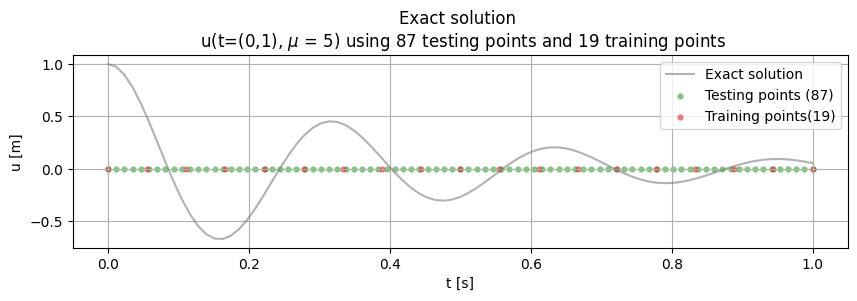

In [24]:
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_physic_in_t_mu[0].detach(), 
        u_exact.detach(), 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.scatter(
        test_physic_in_t_mu[0].detach(), 
        torch.zeros_like(test_physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= f"Testing points ({test_point_resolution})")
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= f"Training points({point_resolution})")

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {test_point_resolution} testing points and {point_resolution} training points")
plt.xlabel('t [s]')
plt.ylabel('u [m]')
plt.grid()
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [25]:
# import os
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.init as init
# import matplotlib.pyplot as plt
# import numpy as np

class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, hidden_layers = [4], N_OUTPUT = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(N_INPUT if i == 0 else hidden_size, hidden_size),
                self.activation
            ) for i, hidden_size in enumerate(hidden_layers[:])   
        ])

        self.fco = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)

        self.plot_weights(fig_size = (10,5), font_size = 8)

    def forward(self, x):
        #x = self.activation(self.fci(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fco(x)
        return x

    def initialize_parameters(self, initialization):
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")
    
    def plot_weights(self, fig_size = (10,5), font_size = 8):
        
        self.fig_size = fig_size
        self.font_size = font_size
        
        weights_biases_dict = self.state_dict()
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize = self.fig_size)
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = self.font_size)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = self.font_size)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = self.font_size, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network', fontsize = self.font_size)
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.ax.tick_params(labelsize = self.font_size)
        
        cbar.set_label('Range of Weights and Biases', fontsize= self.font_size) 
        
        # Show the plots
        plt.show()

class FCN_extended(FCN):
    def __init__(self, N_INPUT, hidden_layers, N_OUTPUT, activation='Tanh', initialization='Xavier', original_model_path=None):
        super().__init__(N_INPUT, hidden_layers, N_OUTPUT, activation, initialization)

        #self.initialize_parameters(initialization)
        
        self.original_model_path = original_model_path
        self.original_state_dict = self.load_original_state_dict()

        self.extend_layers_neurons()
        
    def extend_layers_neurons(self):
        #current_model.initialize_parameters(initialization)  # Initialize current model first
        for name, param in self.named_parameters():
            
            if name in self.original_state_dict:                
                original_param = self.original_state_dict[name]
                
                if param.shape == original_param.shape:                    
                    param.data.copy_(original_param)   
                    
                else:
                    
                    if "weight" in name: 
                        if param.shape != original_param.shape:  
                            # Copy matching portion of old weights                     
                            param.data[:original_param.size(0), :original_param.size(1)].copy_(original_param)
                        
                        elif param.size(0) != original_param.size(0): 
                            # Copy matching portion of old weights                           
                            param.data[:original_param.size(0), :].copy_(original_param)                           
                        
                        elif param.size(0) != original_param.size(0) and "fc0" in name:                            
                            param.data[0,:original_param.size(1)].copy_(original_param[0]) 
               
                    if "bias" in name: 
                        if param.size(0) != original_param.size(0):  
                            # Copy matching portion of old weights
                            param.data[:original_param.size(0)].copy_(original_param)
                        else:
                            param.data.copy_(original_param)     
    
    def load_original_state_dict(self):
        if self.original_model_path is None:
            raise ValueError("Path to the original model checkpoint is not provided.")

        if not os.path.exists(self.self.model_path):
            raise FileNotFoundError(f"Provided path '{self.self.model_path}' does not exist.")

        if not os.path.isfile(self.self.model_path):
            raise ValueError(f"Provided path '{self.self.model_path}' is not a file.")

        _, ext = os.path.splitext(self.self.model_path)
        if ext not in ['.pt', '.pth']:
            raise ValueError("Provided file is not a valid checkpoint file.")
        
        # Load weights and biases from self.model
        return torch.load(self.self.model_path)['model_state_dict']
 
class TrainModel:
    def __init__(self, model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu, u_exact, test_mu = 5, mass = 1, w0 = 20, learning_rate = 0.01, num_epochs= 20000, lambda_ic_dudt= 1e-1, lambda_diff_equat = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200):

        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.checkpoint_interval = checkpoint_interval
        self.stagnation_amplitude = stagnation_amplitude
        self.stagnation_range = stagnation_range

        self.training_ic1_t_mu = ic1_t_mu
        self.training_ic1_scope = ic1_scope
        self.training_ic2_scope = ic2_scope
        self.training_physic_in_t_mu = physic_in_t_mu
        self.training_physic_domain_t_mu = physic_domain_t_mu

        self.test_ic1_t_mu = test_ic1_t_mu
        self.test_ic1_scope = test_ic1_scope 
        self.test_ic2_t_mu = test_ic2_t_mu 
        self.test_ic2_scope = test_ic2_scope 
        self.test_physic_in_t_mu = test_physic_in_t_mu 
        self.test_physic_domain_t_mu = test_physic_domain_t_mu
        
        #self.test_in_t_constant_mu = test_in_t_constant_mu
        
        self.test_mu = test_mu
        self.lambda_ic_dudt = lambda_ic_dudt
        self.lambda_diff_equat = lambda_diff_equat

        self.training_loss_ic1_history = []
        self.training_loss_ic2_history = []
        self.training_loss_differential_equation_history = []
        self.training_loss_total_history = []
        self.training_loss_history = []

        self.test_loss_ic1_history = []
        self.test_loss_ic2_history = []
        self.test_loss_differential_equation_history = []
        self.test_loss_total_history = []
        self.test_loss_history = []

        self.max_stagnation_amplitude_history = []

        self.mass = mass 
        self.w0 = w0
        self.k = self.mass*self.w0**2

        self.u_exact = u_exact(self.test_mu/(2*self.mass), self.w0, self.test_physic_in_t_mu[0])
        
        #self.u_exact()
        
        self.train()
        # self.plot_weights(fig_size = (10,5), font_size = 8) ## plot_weights are defined in class FCN and not in class TrainModel

    def compute_loss(self, ic1_t_mu, ic1_scope, ic2_scope,  physic_domain_t_mu):
        # compute initial condition 1 loss:
        ic1_predicted= self.model(ic1_t_mu)        
        residuals_ic1 = (ic1_predicted - ic1_scope)**2        
        loss_ic1 = torch.mean(residuals_ic1)
    
        # compute initial condition 2 loss:
        du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
        ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
        
        residuals_ic2 = (ic2_du_dt- ic2_scope)**2        
        loss_ic2 = torch.mean(residuals_ic2)
    
        # compute physic loss:
        physic_domain_predicted = self.model(physic_domain_t_mu)
        physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
        physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
        
        residuals_differential_equation = ((1/(self.mass*self.k))*(self.mass * physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + self.k * physic_domain_predicted))**2
        
        loss_differential_equation = torch.mean( residuals_differential_equation)
        
        # compute total loss:
        loss = loss_ic1 + self.lambda_ic_dudt * loss_ic2 + self.lambda_diff_equat * loss_differential_equation
        
        return loss, loss_differential_equation, loss_ic1, loss_ic2, residuals_differential_equation, residuals_ic1, residuals_ic2

    # def compute_loss(self, ic1_t_mu, ic1_scope, ic2_scope,  physic_domain_t_mu):
    #     # compute initial condition 1 loss:
    #     self.ic1_predicted= self.model(self.ic1_t_mu)        
    #     self.residuals_ic1 = self.ic1_predicted - self.ic1_scope        
    #     self.loss_ic1 = torch.mean((self.residuals_ic1)**2)
    
    #     # compute initial condition 2 loss:
    #     self.du_dtdmu_initial = torch.autograd.grad(outputs = self.ic1_predicted, inputs = self.ic1_t_mu, grad_outputs= torch.ones_like(self.ic1_predicted), create_graph= True)[0]
    #     self.ic2_du_dt, ic2_du_dmu = self.du_dtdmu_initial[:, 0:1], self.du_dtdmu_initial[:,1:2]
        
    #     self.residuals_ic2 = self.ic2_du_dt- self.ic2_scope        
    #     self.loss_ic2 = torch.mean((self.residuals_ic2)**2)
    
    #     # compute physic loss:
    #     self.physic_domain_predicted = self.model(self.physic_domain_t_mu)
    #     self.physic_domain_du_dtdmu = torch.autograd.grad(outputs = self.physic_domain_predicted, inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_predicted), create_graph= True)[0]
    #     self.physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = self.physic_domain_du_dtdmu[:,0:1], inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
        
    #     self.residuals_differential_equation = self.physic_domain_d2u_d2t_d2mu[:,0:1] + self.physic_domain_t_mu[:,1:2] * self.physic_domain_du_dtdmu[:,0:1] + self.k * self.physic_domain_predicted 
        
    #     self.loss_differential_equation = torch.mean( (self.residuals_differential_equation)**2)
        
    #     # compute total loss:
    #     self.loss = self.loss_ic1 + self.lambda_ic_dudt * self.loss_ic2 + self.lambda_diff_equat * self.loss_differential_equation
        
    #     return self.loss, self.loss_differential_equation, self.loss_ic1, self.loss_ic2, self.residuals_differential_equation, self.residuals_ic1, self.residuals_ic2
        

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr= self.learning_rate)

        start_time = time.time()
        
        # Predicted values using a constant mu:
        self.test_in_t_constant_mu = torch.stack([torch.linspace(t_interval[0], t_interval[1], test_point_resolution), self.test_mu*torch.ones(test_point_resolution)], -1).view(-1,2)
        
        #self.test_predicted = self.model(self.test_in_t_constant_mu)
        print("+"*200)
        print(f"Initial state using a constant mu({self.test_mu})")
        self.plot_constant_mu(fig_size = (10,2.5))
        print("+"*200)

        for self.i in range(1, self.num_epochs + 1):
            
            # TRAINING MODE for TRAINING LOSS
            
            self.model.train()  # Set model to training mode
            optimizer.zero_grad() # clears the gradients of all optimized parameters. Gradients accumulated from the previous iteration are reset to zero.
            
            # Computation of TRAINING LOSS:
            self.training_loss, self.training_loss_differential_equation, self.training_loss_ic1, self.training_loss_ic2, self.training_residuals_differential_equation, self.training_residuals_ic1, self.training_residuals_ic2 = self.compute_loss(self.training_ic1_t_mu, self.training_ic1_scope, self.training_ic2_scope, self.training_physic_domain_t_mu)

            # For plotting the history:
            self.training_loss_ic1_history.append(self.training_loss_ic1.item())
            self.training_loss_ic2_history.append(self.training_loss_ic2.item())
            self.training_loss_differential_equation_history.append(self.training_loss_differential_equation.item())
            self.training_loss_total_history.append(self.training_loss.item())
            self.training_loss_history.append(self.training_loss.item())
            
            if self.i ==1:                
                self.initial_loss_value = self.training_loss.item()        
            
            self.training_loss.backward() # computes the gradients of the loss with respect to all the learnable parameters of the model (backpropagation)
            optimizer.step()              # updates the parameters of the model based on the computed gradients and the optimization algorithm (e.g., Adam)

            # EVALUATION MODE for TEST LOSS
            #with torch.no_grad():        # disables gradient calculation globally within its context. 
            self.model.eval()  # Set model to evaluation mode
            
                #pde_loss_test = self.compute_pde_loss(x_test, t_test)
                #boundary_loss_test = self.compute_boundary_loss(x_test[0:2], x_test[2:4], t_test[0:2], t_test[2:4])
                #loss_test = pde_loss_test + boundary_loss_test
                # self.test_losses.append(loss_test.item())
                                                                                                                                                                                   #test_ic2_t_mu, test_physic_in_t_mu 
            # Computation of TEST LOSS
            self.test_loss, self.test_loss_differential_equation, self.test_loss_ic1, self.test_loss_ic2, self.test_residuals_differential_equation, self.test_residuals_ic1, self.test_residuals_ic2 = self.compute_loss(self.test_ic1_t_mu, self.test_ic1_scope, self.test_ic2_scope, self.test_physic_domain_t_mu)
            # For plotting the test loss history:
            self.test_loss_ic1_history.append(self.test_loss_ic1.item())
            self.test_loss_ic2_history.append(self.test_loss_ic2.item())
            self.test_loss_differential_equation_history.append(self.test_loss_differential_equation.item())
            self.test_loss_total_history.append(self.test_loss.item())
            self.test_loss_history.append(self.test_loss.item())

            
            # Update loss history and ensure it contains the losses of the last check_range epochs
            if len(self.training_loss_history) and len(self.test_loss_history) > self.stagnation_range:
                self.training_loss_history.pop(0)  # Remove the oldest training loss value
                self.test_loss_history.pop(0)  # Remove the oldest test loss value

            # Check if the difference between max and min loss in the last 100 epochs is within the threshold
            self.max_stagnation_amplitude = max(self.training_loss_history) - min(self.training_loss_history)
            self.max_stagnation_amplitude_history.append(self.max_stagnation_amplitude)
            self.absolut_loss_value = sum(self.training_loss_history) / len(self.training_loss_history)

            if (len(self.training_loss_history) == self.stagnation_range) and (self.max_stagnation_amplitude <= self.stagnation_amplitude)  and  (self.absolut_loss_value < self.initial_loss_value):
                print(f"Stopping training at epoch {self.i} as the loss stabilized within the threshold.")
                print(f"max_stagnation_amplitude = {self.max_stagnation_amplitude} \n absolute_loss_value: {self.absolut_loss_value} ")
                break
            
            if self.i%self.checkpoint_interval == 0:
                print("#"*200)
                print(f"PLOTTING THE RESULTS FOR EPOCH: {self.i}")
                #self.plot_results(self.training_residuals_ic1, self.training_residuals_ic2, self.training_residuals_differential_equation, self.training_loss_ic1_history, self.training_loss_ic2_history, self.training_loss_differential_equation_history, self.training_loss_total_history, self.training_loss_history)
                self.plot_results(fig_size_loss = (10,5),  fig_size_residuals = (10,5))

                torch.save({
                            "epoch": self.i,
                            "model_state_dict": self.model.state_dict(),
                            "optimiser_state_dict": optimizer.state_dict(),
                            "loss": self.training_loss,
                           },                    
                            f"lr{self.learning_rate}_epoch{self.i}.pth")
                print(f"Saved the checkpoint corresponding to epoch: {self.i}")
                print(f"RESULTS PLOTTED FOR EPOCH: {self.i}")
                print("#"*200)
        # Plot of final results:
         #self.plot_results(self.training_residuals_ic1, self.training_residuals_ic2, self.training_residuals_differential_equation, self.training_loss_ic1_history, self.training_loss_ic2_history, self.training_loss_differential_equation_history, self.training_loss_total_history, self.training_loss_history)
        if self.i % self.checkpoint_interval != 0:
            print("*"*200)
            print(f"PLOTTING THE RESULTS FOR LAST EPOCH: {self.i}")
            self.plot_results(fig_size_loss = (10,5),  fig_size_residuals = (10,5))

        # Elapsed time:
        end_time = time.time()
        execution_time = (end_time - start_time)
        print(f"Training elapsed time (s): {execution_time}")
        
        # Final checkpoint:
        torch.save({
                    "epoch": self.i,
                    "model_state_dict": self.model.state_dict(),
                    "optimiser_state_dict": optimizer.state_dict(),
                    "loss": self.training_loss,
                    },                    
                    f"original_model.pth")
        print(f"Saved the checkpoint corresponding to last epoch: {self.i}")

    def plot_constant_mu(self, fig_size = (10,2.5)):
        
        self.test_predicted = self.model(test_in_t_constant_mu)
        
        self.fig_size = fig_size
        plt.figure(figsize=self.fig_size)
        plt.plot(
                self.test_physic_in_t_mu[0].detach(), 
                self.u_exact.detach(), 
                label="Exact solution", 
                color="tab:grey", 
                alpha=0.6
        )
        plt.plot(
                self.test_physic_in_t_mu[0].detach(), 
                self.test_predicted[:,0].detach(), 
                label="PINN solution (initial)", 
                color="tab:green"
        )
        plt.scatter(
                self.training_physic_in_t_mu[0].detach(), 
                torch.zeros_like(self.training_physic_in_t_mu[0]).detach(), 
                s=20, 
                lw=0, 
                color="tab:red",
                alpha=0.6,
                label= f"Training points ({point_resolution})"
        )
        plt.scatter(
                self.test_physic_in_t_mu[0].detach(), 
                torch.zeros_like(self.test_physic_in_t_mu[0]).detach(), 
                s=20, 
                lw=0, 
                color="tab:blue",
                alpha=0.6,
                label=  f"Test points ({test_point_resolution})"
        )
        ### model and activation has to be manually adapted
        # original_input_size, original_hidden_layers, original_output_size
        #plt.title(f"Exact and predicted solution for a nn with following architecture: [{self.model.original_input_size}, {self.model.original_hidden_layers}, {self.model.original_output_size}] \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation}, epoch = 1")
        #plt.title(f"Exact and predicted solution for a nn with following architecture: [X, Y, Z] \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation}, epoch = 1")
        plt.title(f"Exact and predicted solution \n (NN Architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}]) \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}")
        plt.xlabel('t [s]')
        plt.ylabel('u [m]')
        plt.grid()
        plt.legend()
        plt.show()
        

    
#    def plot_results(self, residuals_ic1, residuals_ic2, residuals_differential_equation, loss_ic1_history, loss_ic2_history, loss_differential_equation_history, loss_total_history, loss_history, fig_size_loss = (10,5),  fig_size_residuals = (10,5)):
    def plot_results(self, fig_size_loss = (10,5),  fig_size_residuals = (10,5)):
        self.fig_size_loss = fig_size_loss
        self.fig_size_residuals = fig_size_residuals
        
        print(f"Maximum stagnation amplitude by the loss convergence: {self.max_stagnation_amplitude}")
        print(f'Decomposition of the TRAINING loss terms: \n loss({self.training_loss}) = loss1({self.training_loss_ic1}) + {self.lambda_ic_dudt} * loss2({self.training_loss_ic2}) + {self.lambda_diff_equat} * loss3({self.training_loss_differential_equation})')
        print(f'Decomposition of the TEST loss terms: \n loss({self.test_loss}) = loss1({self.test_loss_ic1}) + {self.lambda_ic_dudt} * loss2({self.test_loss_ic2}) + {self.lambda_diff_equat} * loss3({self.test_loss_differential_equation})')

        self.plot_constant_mu(fig_size = (10,2.5))
        
        # plt.figure(figsize = self.fig_size_loss)
        # plt.plot(self.test_physic_in_t_mu[0].detach().numpy(), 
        #          self.u_exact.detach().numpy(), 
        #          label="Exact solution", 
        #          color="tab:grey", 
        #          alpha=0.6
        # )
        # plt.plot(
        #         self.test_physic_in_t_mu[0].detach().numpy(), 
        #         self.test_predicted[:,0].detach().numpy(), 
        #         label="PINN solution", 
        #         color="tab:green"
        # )
        # plt.scatter(
        #             self.training_physic_in_t_mu[0].detach().numpy(), 
        #             torch.zeros_like(self.training_physic_in_t_mu[0]), 
        #             s=20, 
        #             lw=0, 
        #             color="tab:red",
        #             alpha=0.6,
        #             label= "Training points"
        # )
        # plt.scatter(
        #             self.test_physic_in_t_mu[0].detach().numpy(), 
        #             torch.zeros_like(self.test_physic_in_t_mu[0]), 
        #             s=20, 
        #             lw=0, 
        #             color="tab:green",
        #             alpha=0.6,
        #             label= "Testing points"
        # )
        # #plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation()}, epoch = {self.i} \n (learning rate: {learning_rate}, lambda_ic_dudt: {lambda_ic_dudt}, lambda_diff_equat: {lambda_diff_equat})")
        # plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: Tanh, epoch = {self.i} \n (learning rate: {self.learning_rate}, lambda_ic_dudt: {self.lambda_ic_dudt}, lambda_diff_equat: {self.lambda_diff_equat})")
        # plt.grid()
        # plt.legend()
        # plt.show()
        
        ######################################
        # # Loss history:
        # # Plot the loss history as before
        # fig, axs = plt.subplots(nrwos = 1, ncols = 4, figsize=(5, 3))
        # #plt.figure(figsize=(5, 3))
        # plt.plot(self.training_loss_history, label= f'Training Loss' )
        # plt.plot(self.test_loss_history, label= f'Test Loss' )
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title(f'Training and Test Loss: last {self.stagnation_range} epochs')
        # plt.legend()
        # plt.show()
        # # 
        # plt.figure(figsize=(5, 3))
        # plt.plot(self.training_loss_total_history, label='Training Loss')
        # plt.plot(self.test_loss_total_history, label='Test Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Total Loss history: whole history')
        # plt.legend()
        # plt.show()
        # ######################################
        # # max_stagnation_amplitude
        # plt.figure(figsize=(5, 3))
        # plt.plot(self.max_stagnation_amplitude_history)
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss amplitude')
        # plt.title('Max. Loss amplitude: whole history')
        # plt.show()


        ######################################
        ######################################
        # Total Loss history:
        # Plot the loss history as before
        fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))
        #plt.figure(figsize=(5, 3))
        fig.suptitle(f"Total Loss history (epoch: {self.i})", fontsize = 14)

        axs[0].plot(self.training_loss_total_history, label='Training Loss')
        axs[0].plot(self.test_loss_total_history, label='Test Loss')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Total Loss')
        axs[0].set_title('Total Loss history: whole history')
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(self.training_loss_total_history[-1000:], label='Training Loss')
        axs[1].plot(self.test_loss_total_history[-1000:], label='Test Loss')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Total Loss')
        axs[1].set_title(f'Total Training and Test Loss: last 1000 epochs')
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(self.training_loss_history, label= 'Training Loss' )
        axs[2].plot(self.test_loss_history, label= 'Test Loss' )
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Total Loss')
        axs[2].set_title(f'Total Training and Test Loss: last {self.stagnation_range} epochs')
        axs[2].legend()
        axs[2].grid(True)
        ######################################
        ######################################
        # Maximum stagnation amplitude by the convergence
        fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))
        #plt.figure(figsize=(5, 3))
        fig.suptitle(f" Maximum stagnation amplitude by the convergence (epoch: {self.i})", fontsize = 14)
        # max_stagnation_amplitude
        axs[0].plot(self.max_stagnation_amplitude_history)
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss amplitude')
        axs[0].set_title('Maximum stagnation amplitude of the Total Loss: whole history')
        axs[0].grid(True)
        # max_stagnation_amplitude
        axs[1].plot(self.max_stagnation_amplitude_history[-100:])
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss amplitude')
        axs[1].set_title(f'Maximum stagnation amplitude of the Total Loss: last {self.stagnation_range} epochs')
        axs[1].grid(True)
        ######################################      
        ######################################
        # plot the contribution of every loss term (loss1, loss2 and loss3)
        fig, axs = plt.subplots(nrows= 2, ncols= 2, layout = 'constrained', sharex = False, figsize = (20,10))
        #fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda_ic_dudt: {lambda_ic_dudt}, lambda_diff_equat: {lambda_diff_equat})", fontsize = 14)
        fig.suptitle(f"Decomposition of the loss terms using {self.model.__class__.__name__} model and Tanh activation function \n (learning_rate: {self.learning_rate}, lambda_ic_dudt: {self.lambda_ic_dudt}, lambda_diff_equat: {self.lambda_diff_equat}, (epoch: {self.i})", fontsize = 14)
        
        axs[0,0].plot(self.training_loss_ic1_history, '-', label = "training loss1: residuals of u(t=0)=0", color = "tab:red")
        axs[0,0].plot(self.training_loss_ic2_history, '-', label = "training loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        axs[0,0].plot(self.test_loss_ic1_history, '--', label = "test loss1: residuals of u(t=0)=1", color = "tab:red")
        axs[0,0].plot(self.test_loss_ic2_history, '--', label = "test loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        axs[0,0].set_title("Training and test loss1 (u(t=0)=1) and loss2 (du/dt(t=0)=0)")
        axs[0,0].set_xlabel("Epochs")
        #axs[0,0].set_xlim(0,1000)
        axs[0,0].set_ylabel("Loss")
        axs[0,0].grid()
        axs[0,0].legend()

        axs[0,1].plot(self.training_loss_ic1_history[-100:], '-', label = "training loss1: residuals of u(t=0)=1", color = "tab:red")
        axs[0,1].plot(self.training_loss_ic2_history[-100:], '-', label = "training loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        axs[0,1].plot(self.test_loss_ic1_history[-100:], '--', label = "test loss1: residuals of u(t=0)=1", color = "tab:red")
        axs[0,1].plot(self.test_loss_ic2_history[-100:], '--', label = "test loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        axs[0,1].set_title("Training and test loss1: (u(t=0)=1) and training and test loss2: (du/dt(t=0)=0) (last 100 epochs)")
        axs[0,1].set_xlabel("Epochs")
        axs[0,1].set_ylabel("Loss")
        axs[0,1].set_xlim(0,100)
        axs[0,1].grid()
        axs[0,1].legend()
        
        axs[1,0].plot(self.training_loss_differential_equation_history, '-', label= "training loss3: residuals of the differential equation", color = "tab:grey")
        axs[1,0].plot(self.test_loss_differential_equation_history, '--', label= "test loss3: residuals of the differential equation", color = "tab:grey")
        axs[1,0].set_title("Training and test loss3: residuals of the differential equation (whole history)")
        axs[1,0].set_xlabel("Epochs")
        axs[1,0].set_ylabel("Loss")
        axs[1,0].legend()
        axs[1,0].grid()

        axs[1,1].plot(self.training_loss_differential_equation_history[-100:], '-', label= "training loss3: residuals of the differential equation", color = "tab:grey")
        axs[1,1].plot(self.test_loss_differential_equation_history[-100:], '--', label= "test loss3: residuals of the differential equation", color = "tab:grey")
        axs[1,1].set_title("Training and test loss3: residuals of the differential equation (last 100 epochs)")
        axs[1,1].set_xlabel("Epochs")
        axs[1,1].set_ylabel("Loss")
        axs[1,1].set_xlim(0,100)
        axs[1,1].legend()
        axs[1,1].grid()
        
        # # plot the contribution of every loss term (loss1, loss2 and loss3)
        # fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (12,5))
        # #fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda_ic_dudt: {lambda_ic_dudt}, lambda_diff_equat: {lambda_diff_equat})", fontsize = 14)
        # fig.suptitle(f"Decomposition of the loss terms using {self.model.__class__.__name__} model and Tanh activation function \n (learning_rate: {self.learning_rate}, lambda_ic_dudt: {self.lambda_ic_dudt}, lambda_diff_equat: {self.lambda_diff_equat})", fontsize = 14)
        
        # loss1_2.plot(self.training_loss_ic1_history, '-', label = "training loss1: residuals of u(t=0)=1", color = "tab:red")
        # loss1_2.plot(self.training_loss_ic2_history, '-', label = "training loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        # loss1_2.plot(self.test_loss_ic1_history, '--', label = "test loss1: residuals of u(t=0)=1", color = "tab:red")
        # loss1_2.plot(self.test_loss_ic2_history, '--', label = "test loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        # loss1_2.set_title("training and test loss1: (u(t=0)=1) and training and test loss2: (du/dt(t=0)=0)")
        # loss1_2.set_xlabel("epochs")
        # loss1_2.set_ylabel("residuals")
        # loss1_2.grid()
        # loss1_2.legend()
        
        # loss3.plot(self.training_loss_differential_equation_history, '-', label= "training loss3: residuals of the differential equation", color = "tab:grey")
        # loss3.plot(self.test_loss_differential_equation_history, '--', label= "test loss3: residuals of the differential equation", color = "tab:grey")
        # loss3.set_title("training and test loss3: residuals of the differential equation")
        # loss3.set_xlabel("epochs")
        # loss3.set_ylabel("residuals")
        # loss3.legend()
        # loss3.grid()        
        
        ######################################      
        ######################################
    #     # RESIDUAL DISTRIBUTION in the T-MU SUBSPACE (CONTOURF):
    # #def plot_pinn_points (self, ic1_t_mu, ic2_t_mu, physic_domain_t_mu, point_resolution, test_ic1_t_mu, test_ic2_t_mu, test_physic_domain_t_mu, test_point_resolution, figsize = (15,7.5)):
    #     ## Plotting initial conditions training and test points:
    #     plt.figure(figsize = fig_size_residuals)
        
    #     # Contour plot
    #     contour = plt.contourf(physic_domain_t_mu[:,0].reshape(point_resolution,point_resolution).detach().numpy(), physic_domain_t_mu[:,1].reshape(point_resolution,point_resolution).detach().numpy(), self.training_residuals_differential_equation.reshape(point_resolution,point_resolution).detach().numpy(), cmap='hot', levels = 40)  # Using 'hot' colormap for heatmap
    #     #plt.colorbar(contour)  # Add color bar for reference
    #     # Create a colorbar associated with the contour plot
    #     cbar = plt.colorbar(contour)
    #     # Set the colorbar ticks to match the contour levels
    #     cbar.set_ticks(contour.levels)
    #     ##plt.xlabel('t')
    #     ##plt.ylabel('mu')
    #     ##plt.title(f'Location of initial conditions, training points ({point_resolution}) and test points ({test_point_resolution})')
        
    #     # plt.scatter(
    #     #             ic1_t_mu[:, 0].detach(), 
    #     #             ic1_t_mu[:, 1].detach(), 
    #     #             color="blue",
    #     #             label="Initial condition 1",
    #     #             #color="tab:grey",
    #     #             marker = 'x',
    #     #             alpha=0.6,
    #     #             s=20
    #     #             )
    #     # plt.scatter(
    #     #             ic2_t_mu[:, 0].detach(), 
    #     #             ic2_t_mu[:, 1].detach(), 
    #     #             color="red",
    #     #             label="Initial condition 2",
    #     #             #color="tab:grey",
    #     #             marker = '+',
    #     #             alpha=0.6,
    #     #             s=20
    #     #             )           
    #     # plt.scatter(
    #     #             physic_domain_t_mu[:, 0].detach(), 
    #     #             physic_domain_t_mu[:, 1].detach(), 
    #     #             color="black",
    #     #             label="Training points",
    #     #             #color="tab:grey",
    #     #             marker = "D",
    #     #             alpha=0.6,
    #     #             s=20
    #     #             ) 
    #     # #############################################################
    #     # plt.scatter(
    #     #             test_ic1_t_mu[:, 0].detach(), 
    #     #             test_ic1_t_mu[:, 1].detach(), 
    #     #             color="red",
    #     #             label="Test Initial condition 1",
    #     #             #color="tab:grey",
    #     #             marker = 's',
    #     #             alpha=0.6,
    #     #             s=20
    #     #             )
    #     # plt.scatter(
    #     #             test_ic2_t_mu[:, 0].detach(), 
    #     #             test_ic2_t_mu[:, 1].detach(), 
    #     #             color="red",
    #     #             label="Test Initial condition 2",
    #     #             #color="tab:grey",
    #     #             marker = 's',
    #     #             alpha=0.6,
    #     #             s=20
    #     #             )           
    #     # plt.scatter(
    #     #             test_physic_domain_t_mu[:, 0].detach(), 
    #     #             test_physic_domain_t_mu[:, 1].detach(), 
    #     #             color="green",
    #     #             label="Test points",
    #     #             #color="tab:grey",
    #     #             marker = "s",
    #     #             alpha=0.6,
    #     #             s=20
    #     #             ) 
        
    #     plt.xlabel('t')
    #     plt.ylabel(f'$\mu$')
    #     plt.title(f'Distribution of the Residuals**2 \n and location of initial conditions points, training points ({point_resolution}) and test points ({test_point_resolution}) \n (epoch: {self.i})')
    #     #plt.legend(loc = "upper right")
    #     plt.grid(True)
    #     plt.show()

    #     #----------------------
    #     plt.figure(figsize = fig_size_residuals)
        
    #     # Contour plot
    #     contour = plt.contourf(test_physic_domain_t_mu[:,0].reshape(test_point_resolution, test_point_resolution).detach().numpy(), test_physic_domain_t_mu[:,1].reshape(test_point_resolution, test_point_resolution).detach().numpy(), self.test_residuals_differential_equation.reshape(test_point_resolution, test_point_resolution).detach().numpy(), cmap='hot', levels = 40)  # Using 'hot' colormap for heatmap
    #     #plt.colorbar(contour)  # Add color bar for reference
    #     # Create a colorbar associated with the contour plot
    #     cbar = plt.colorbar(contour)
    #     # Set the colorbar ticks to match the contour levels
    #     cbar.set_ticks(contour.levels)
    #     plt.xlabel('t')
    #     plt.ylabel(f'$\mu$')
    #     plt.title(f'Distribution of the Residuals**2 \n and location of initial conditions points, training points ({point_resolution}) and test points ({test_point_resolution}) \n (epoch: {self.i})')
    #     #plt.legend(loc = "upper right")
    #     plt.grid(True)
    #     plt.show()

         # Plotting initial conditions training and test points:
        fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (25,20)) # fig_size_residuals

        fig.suptitle(f'Distribution of the Residuals**2 and location of initial conditions points, training points ({point_resolution}) and test points ({test_point_resolution}) \n (epoch: {self.i}) by TRAINING and TEST')
                     
        # Contour plot TRAINING residuals differential equation
        contour_plot_training = ax1.contourf(physic_domain_t_mu[:,0].reshape(point_resolution, point_resolution).detach().numpy(), physic_domain_t_mu[:,1].reshape(point_resolution, point_resolution).detach().numpy(), self.training_residuals_differential_equation.reshape(point_resolution, point_resolution).detach().numpy(), cmap='hot', levels = 40)  # Using 'hot' colormap for heatmap
        contour_bar_training = fig.colorbar(contour_plot_training, ax= ax1, orientation = "vertical") # Create a colorbar associated with the contour plot
        contour_bar_training.set_ticks(contour_plot_training.levels)                                  # Set the colorbar ticks to match the contour levels
        ax1.scatter(
                    self.training_ic1_t_mu[:, 0].detach(), 
                    self.training_ic1_t_mu[:, 1].detach(), 
                    color="blue",
                    label="Initial condition 1",
                    #color="tab:grey",
                    marker = 'x',
                    linewidths=2,
                    alpha=0.6,
                    s=20
                    )
        ax1.scatter(
                    ic2_t_mu[:, 0].detach(), 
                    ic2_t_mu[:, 1].detach(), 
                    color="red",
                    label="Initial condition 2",
                    #color="tab:grey",
                    marker = '+',
                    linewidths=2,
                    alpha=0.6,
                    s=20
                    )           
        ax1.scatter(
                    self.training_physic_domain_t_mu[:, 0].detach(), 
                    self.training_physic_domain_t_mu[:, 1].detach(), 
                    color="white",
                    label="Training points",
                    #color="tab:grey",
                    marker = "D",
                    alpha=0.6,
                    s=20
                    ) 
        ax1.set_xlabel('t')
        ax1.set_ylabel(f'$\mu$')
        ax1.set_title(f'Residuals of differential equation (training points ({point_resolution}))')
        ax1.grid(True)


        # Contour plot TEST residuals differential equation
        contour_plot_test = ax2.contourf(test_physic_domain_t_mu[:,0].reshape(test_point_resolution, test_point_resolution).detach().numpy(), test_physic_domain_t_mu[:,1].reshape(test_point_resolution, test_point_resolution).detach().numpy(), self.test_residuals_differential_equation.reshape(test_point_resolution, test_point_resolution).detach().numpy(), cmap='hot', levels = 40)  # Using 'hot' colormap for heatmap
        contour_bar_test = fig.colorbar(contour_plot_test, ax= ax2, orientation = "vertical") # Create a colorbar associated with the contour plot
        contour_bar_test.set_ticks(contour_plot_test.levels)                                  # Set the colorbar ticks to match the contour levels
        ax2.scatter(
                    self.test_ic1_t_mu[:, 0].detach(), 
                    self.test_ic1_t_mu[:, 1].detach(), 
                    color="blue",
                    label="Initial condition 1",
                    #color="tab:grey",
                    marker = 'x',
                    linewidths=2,
                    alpha=0.6,
                    s=20
                    )
        ax2.scatter(
                    test_ic2_t_mu[:, 0].detach(), 
                    test_ic2_t_mu[:, 1].detach(), 
                    color="red",
                    label="Initial condition 2",
                    #color="tab:grey",
                    marker = '+',
                    linewidths=2,
                    alpha=0.6,
                    s=20
                    )           
        ax2.scatter(
                    self.test_physic_domain_t_mu[:, 0].detach(), 
                    self.test_physic_domain_t_mu[:, 1].detach(), 
                    color="white",
                    label="Training points",
                    #color="tab:grey",
                    marker = "D",
                    alpha=0.6,
                    s=20
                    ) 
        ax2.set_xlabel('t')
        ax2.set_ylabel(f'$\mu$')
        ax2.set_title(f'Residuals of differential equation (test points ({test_point_resolution}))')
        ax2.grid(True)

        plt.show()


        # # Contour plot
        # ax2.contourf(test_physic_domain_t_mu[:,0].reshape(test_point_resolution, test_point_resolution).detach().numpy(), test_physic_domain_t_mu[:,1].reshape(test_point_resolution, test_point_resolution).detach().numpy(), self.test_residuals_differential_equation.reshape(test_point_resolution, test_point_resolution).detach().numpy(), cmap='hot', levels = 40)  # Using 'hot' colormap for heatmap
        # #plt.colorbar(contour)  # Add color bar for reference
        # # Create a colorbar associated with the contour plot
        # cbar = plt.colorbar(contour)
        # # Set the colorbar ticks to match the contour levels
        # cbar.set_ticks(contour.levels)
        # plt.xlabel('t')
        # plt.ylabel(f'$\mu$')
        # plt.title(f'Distribution of the Residuals**2 \n and location of initial conditions points, training points ({point_resolution}) and test points ({test_point_resolution}) \n (epoch: {self.i})')
        # #plt.legend(loc = "upper right")
        # plt.grid(True)
        # plt.show()




In [26]:
#torch.rand(1,10, 40).shape

## STEP 3: Instantiate the Model Class

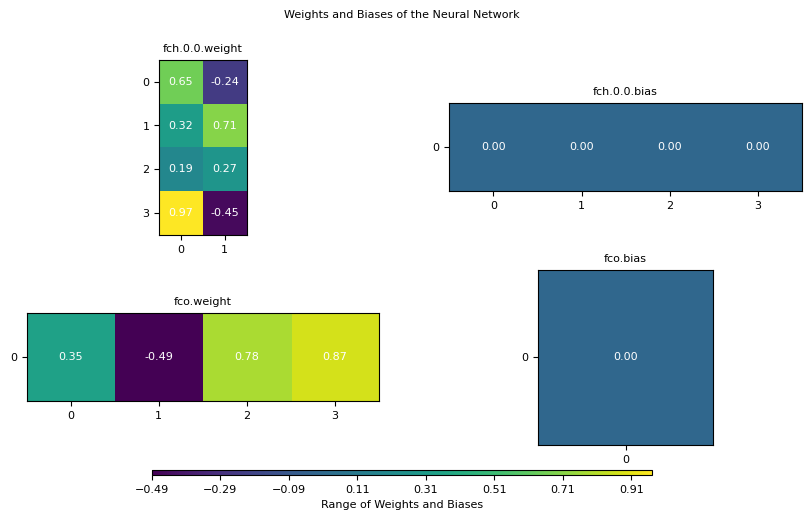

In [27]:
original_input_size = 2
original_hidden_layers =[4] # [4] #[64,64,64,64]
original_output_size = 1
original_model = FCN(original_input_size, original_hidden_layers, original_output_size, activation='Tanh', initialization='Xavier')
#original_model.plot_weights()

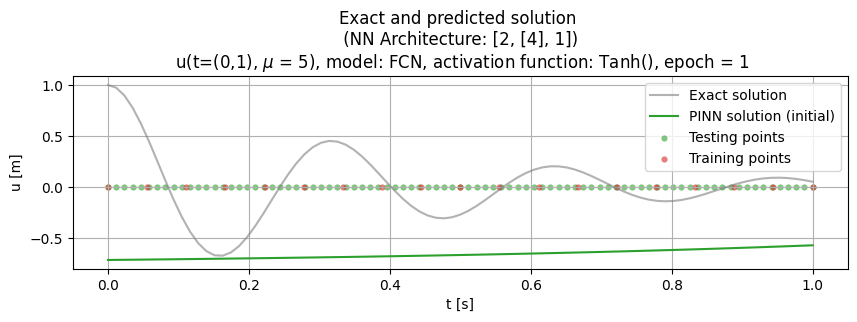

In [28]:
test_mu = 5
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,test_point_resolution), test_mu*torch.ones(test_point_resolution)], -1).view(-1,2)
test_predicted = original_model(test_in_t_constant_mu)

# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_physic_in_t_mu[0].detach(), 
        u_exact.detach(), 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6)
plt.plot(test_physic_in_t_mu[0].detach(), 
        test_predicted[:,0].detach(), 
        label="PINN solution (initial)", 
        color="tab:green"
)
plt.scatter(
        test_physic_in_t_mu[0].detach(), 
        torch.zeros_like(test_physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Testing points")
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= "Training points")
plt.title(f"Exact and predicted solution \n (NN Architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}]) \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}, epoch = 1")
#plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {test_point_resolution} testing points")
plt.xlabel('t [s]')
plt.ylabel('u [m]')
plt.grid()
plt.legend()
plt.show()

## STEP 4: Training the PINN

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Initial state using a constant mu(5)


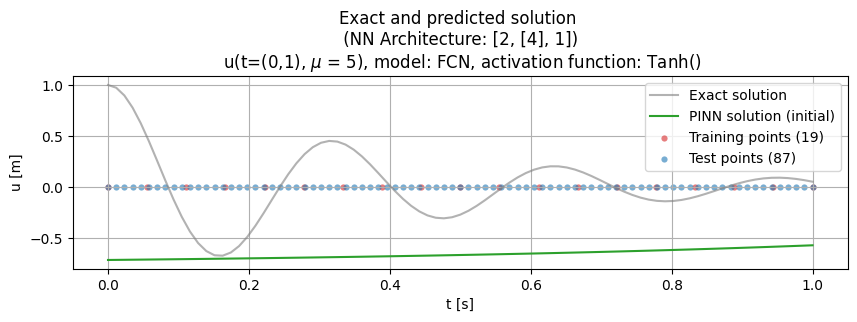

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 1000
Maximum stagnation amplitude by the loss convergence: 0.014325886964797974
Decomposition of the TRAINING loss terms: 
 loss(0.4312573969364166) = loss1(0.16853304207324982) + 1 * loss2(0.034670282155275345) + 1 * loss3(0.22805407643318176)
Decomposition of the TEST loss terms: 
 loss(0.43021535873413086) = loss1(0.16646182537078857) + 1 * loss2(0.0343795008957386) + 1 * loss3(0.2293740212917328)


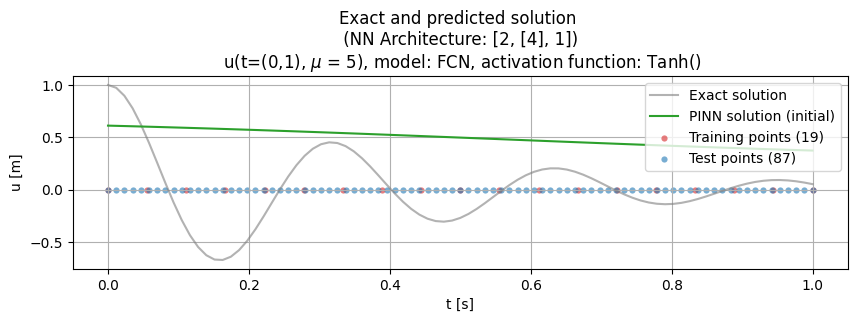

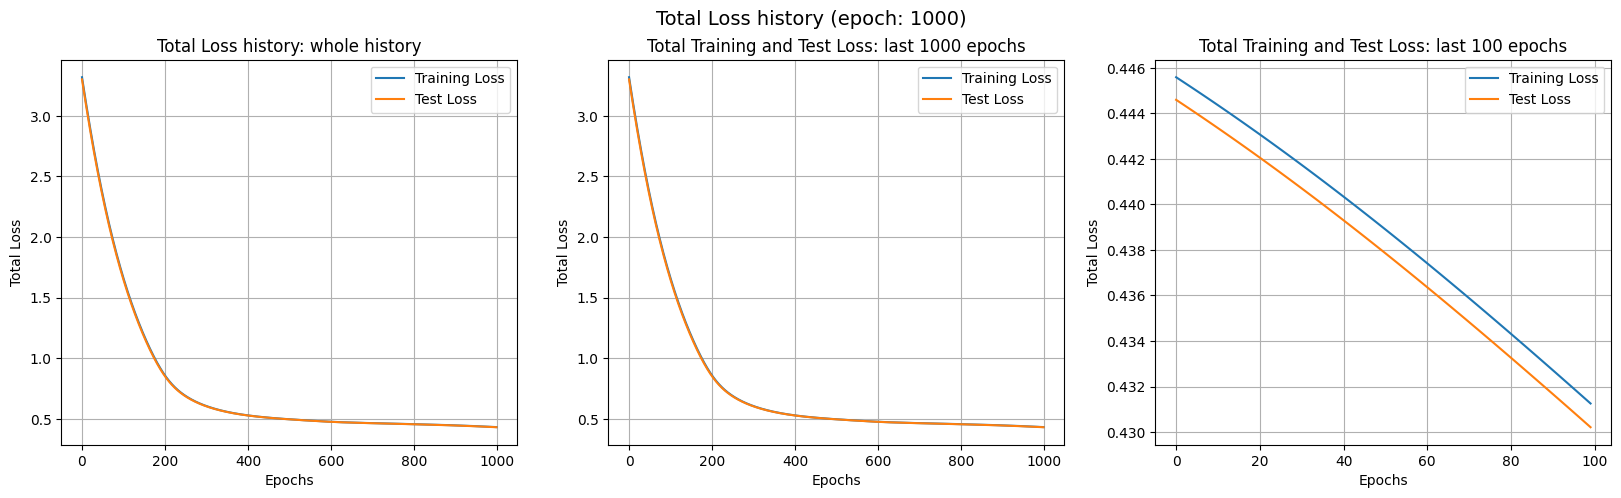

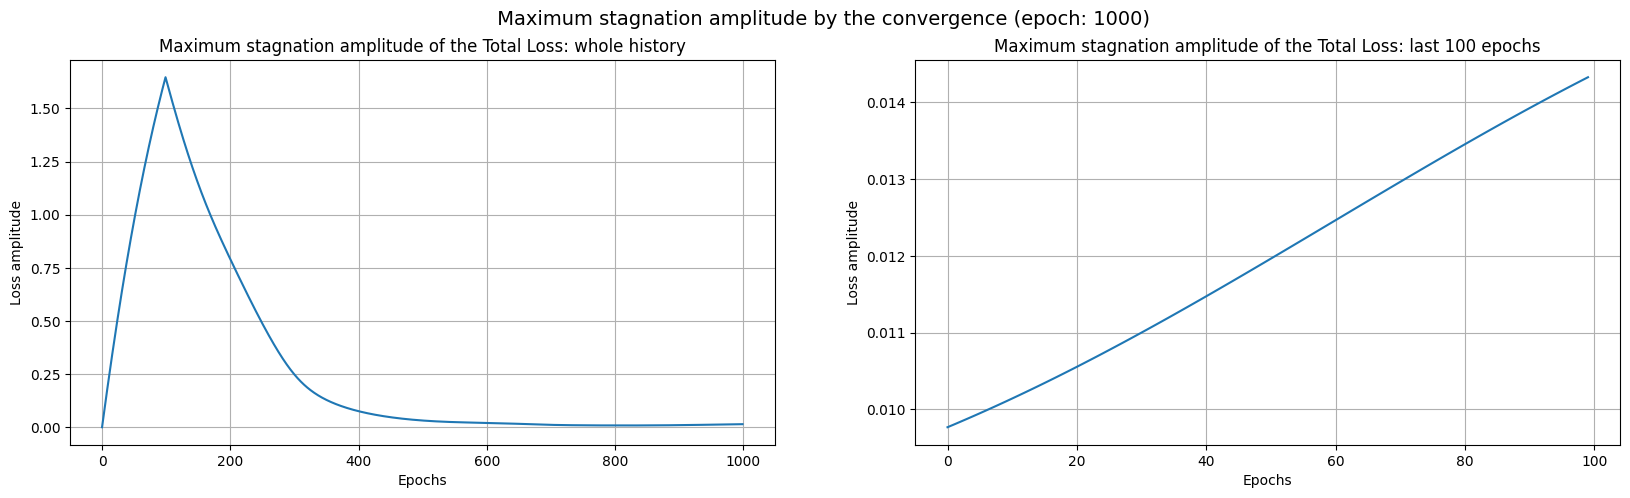

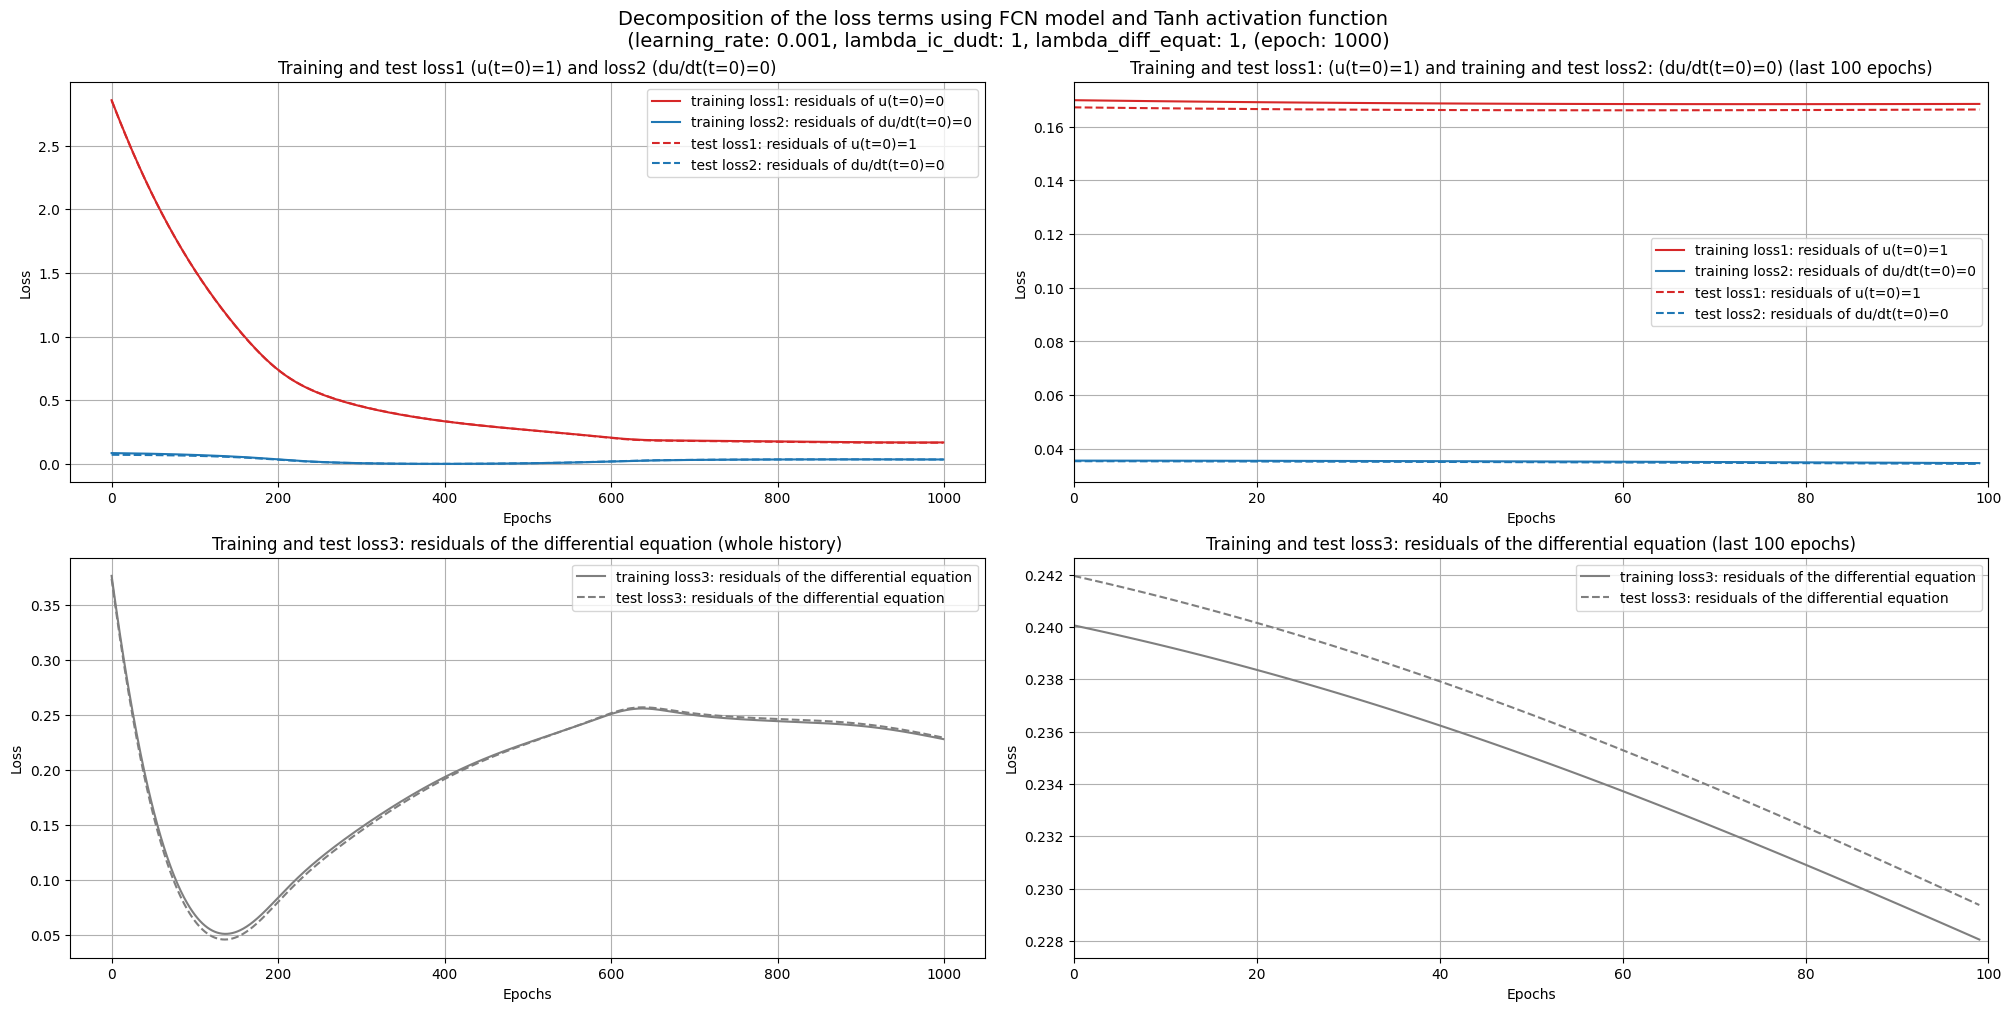

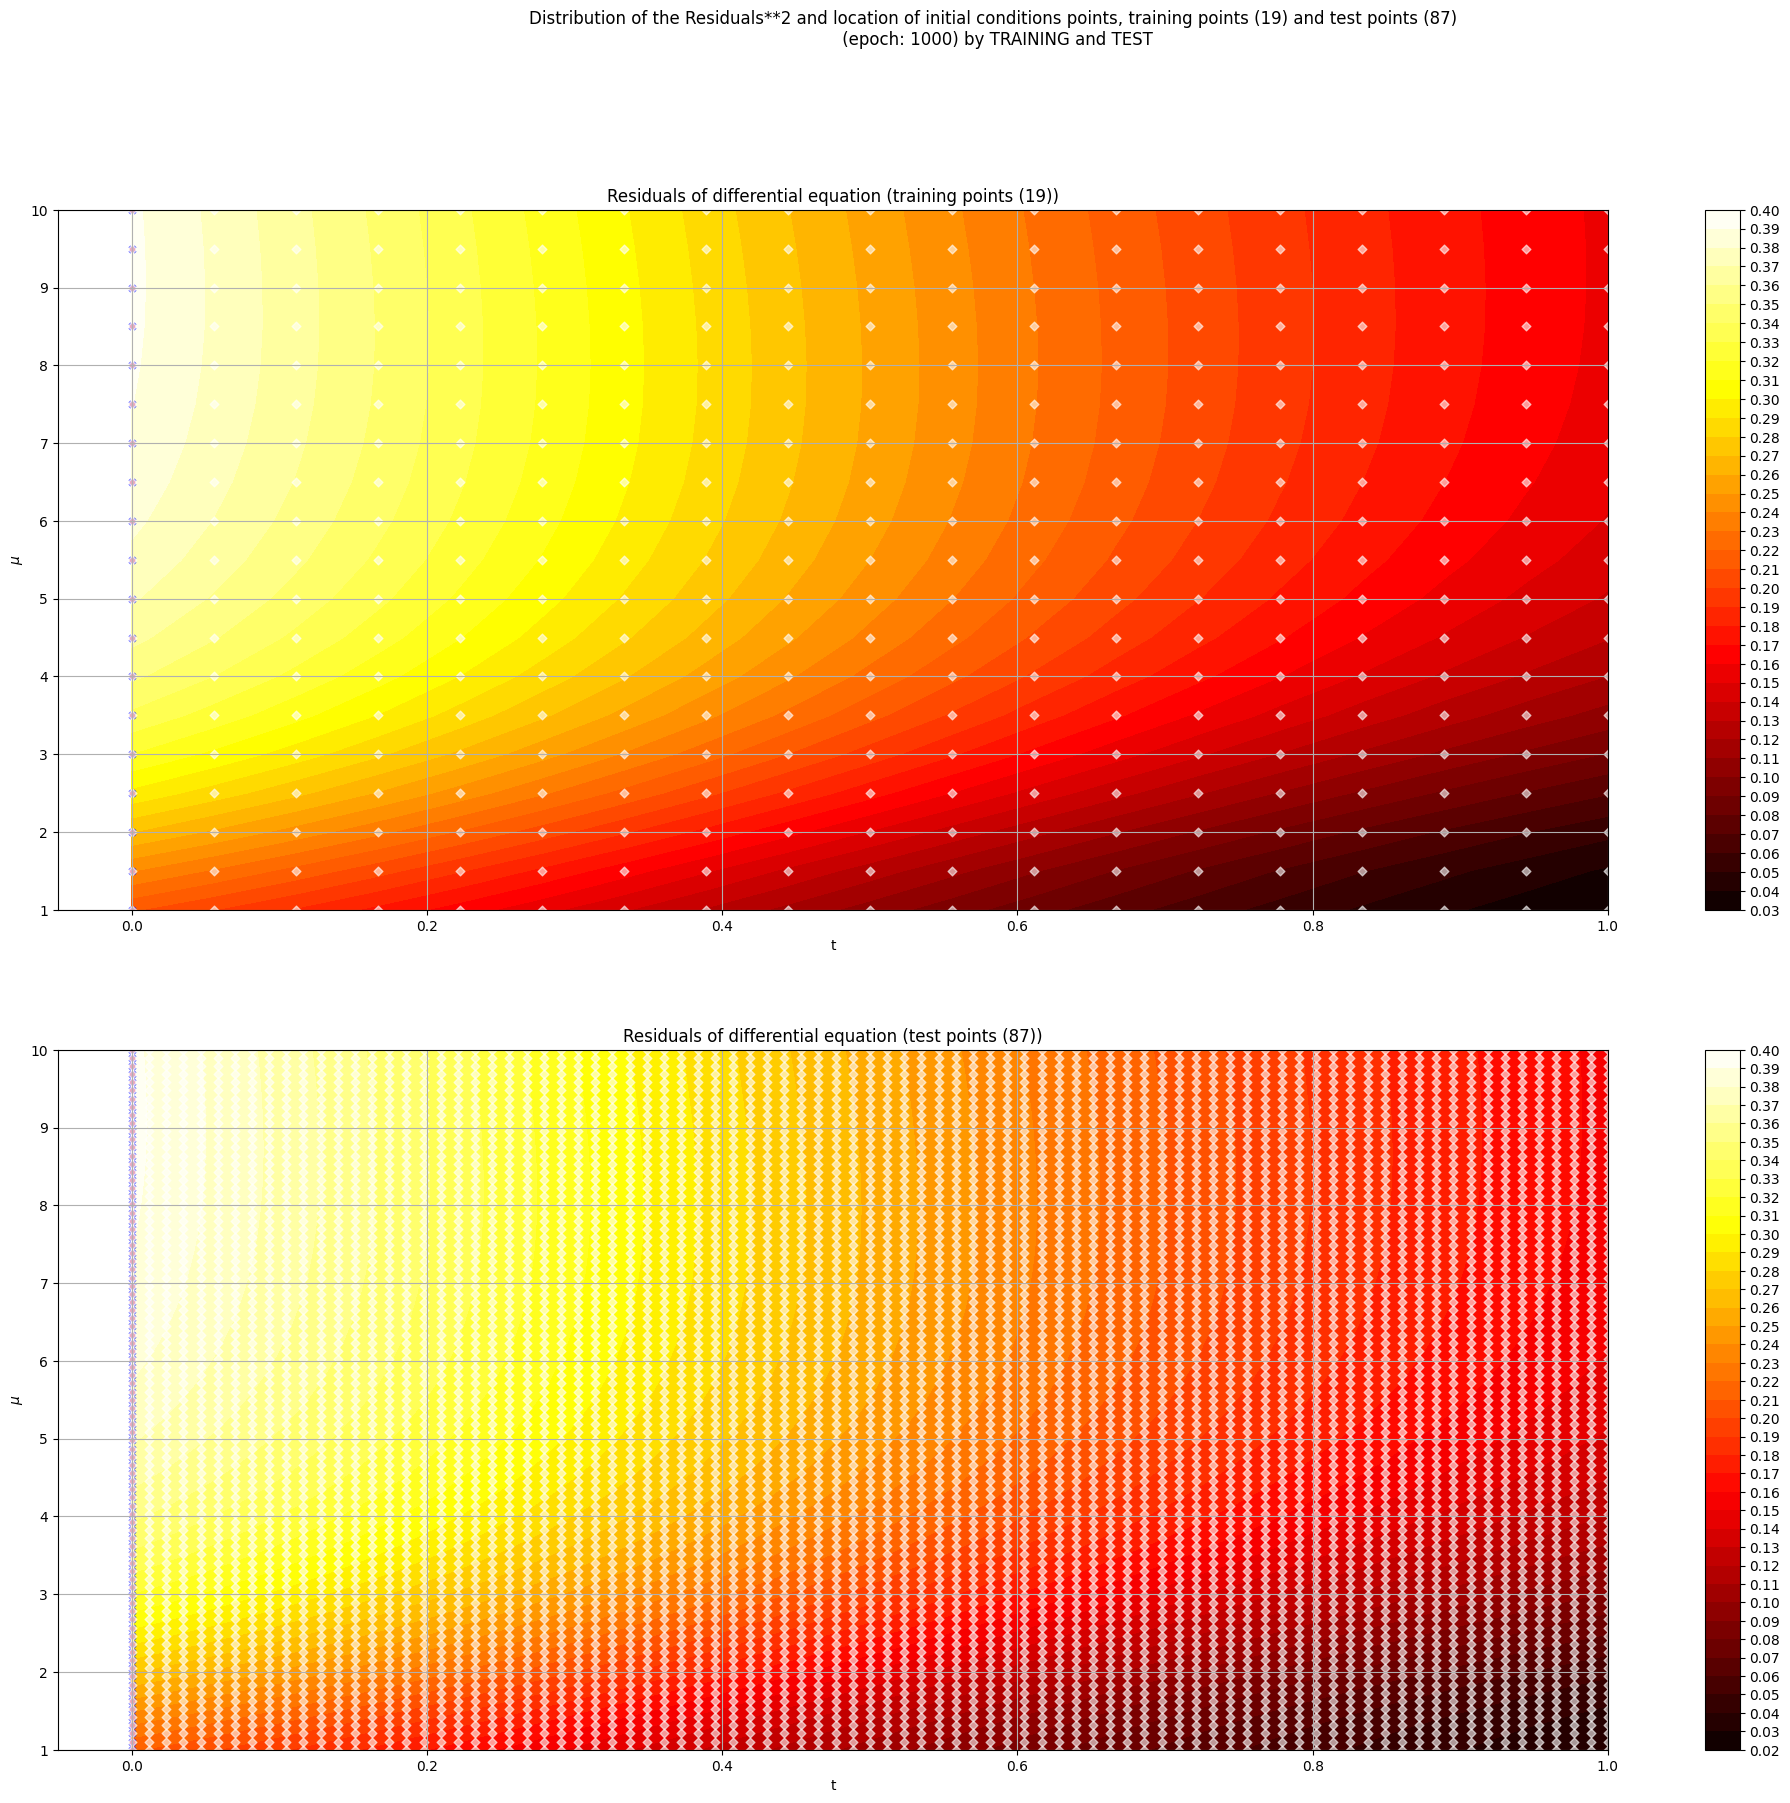

Saved the checkpoint corresponding to epoch: 1000
RESULTS PLOTTED FOR EPOCH: 1000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 2000
Maximum stagnation amplitude by the loss convergence: 0.011817127466201782
Decomposition of the TRAINING loss terms: 
 loss(0.29384058713912964) = loss1(0.10751841962337494) + 1 * loss2(0.019833745434880257) + 1 * loss3(0.1664884388446808)
Decomposition of the TEST loss terms: 
 loss(0.29116326570510864) = loss1(0.108101986348629) + 1 * loss2(0.01966208592057228) + 1 * loss3(0.16339920461177826)


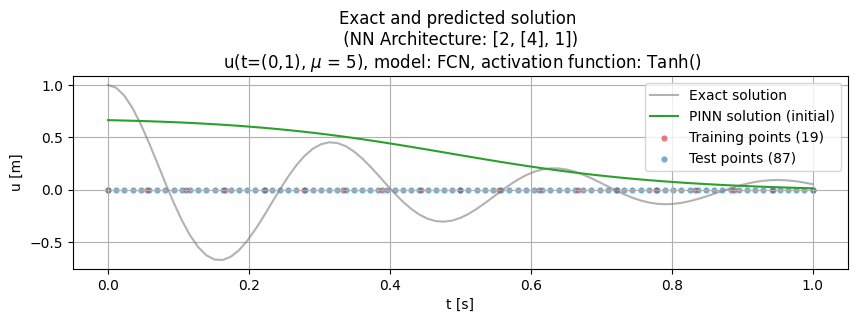

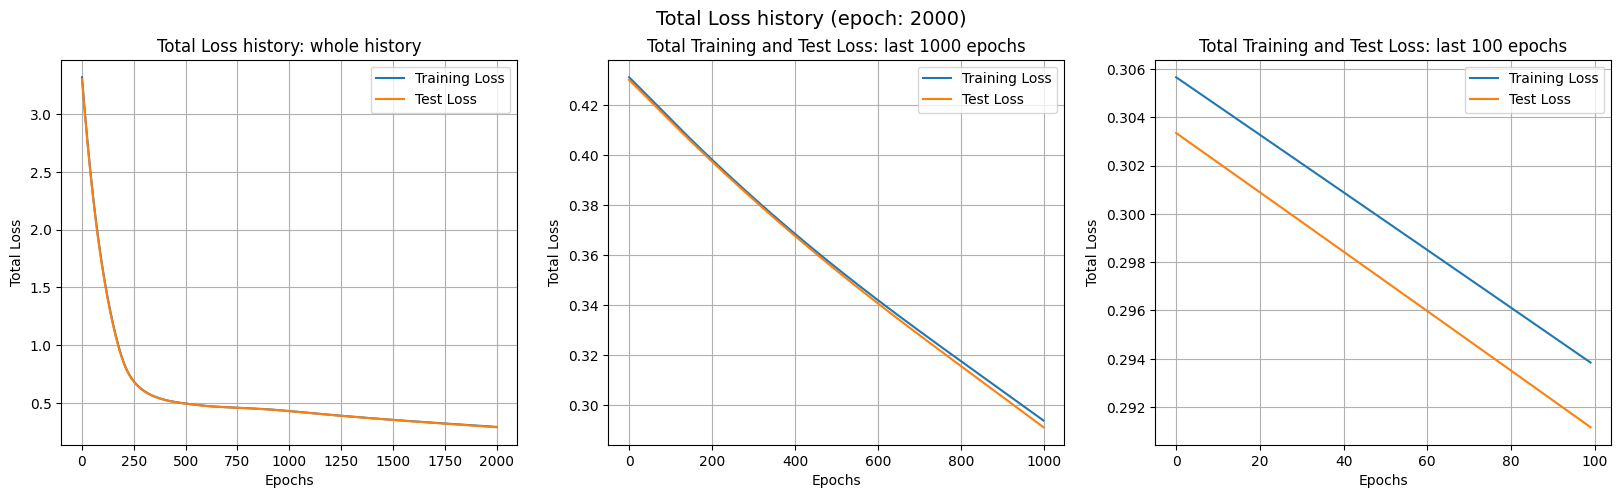

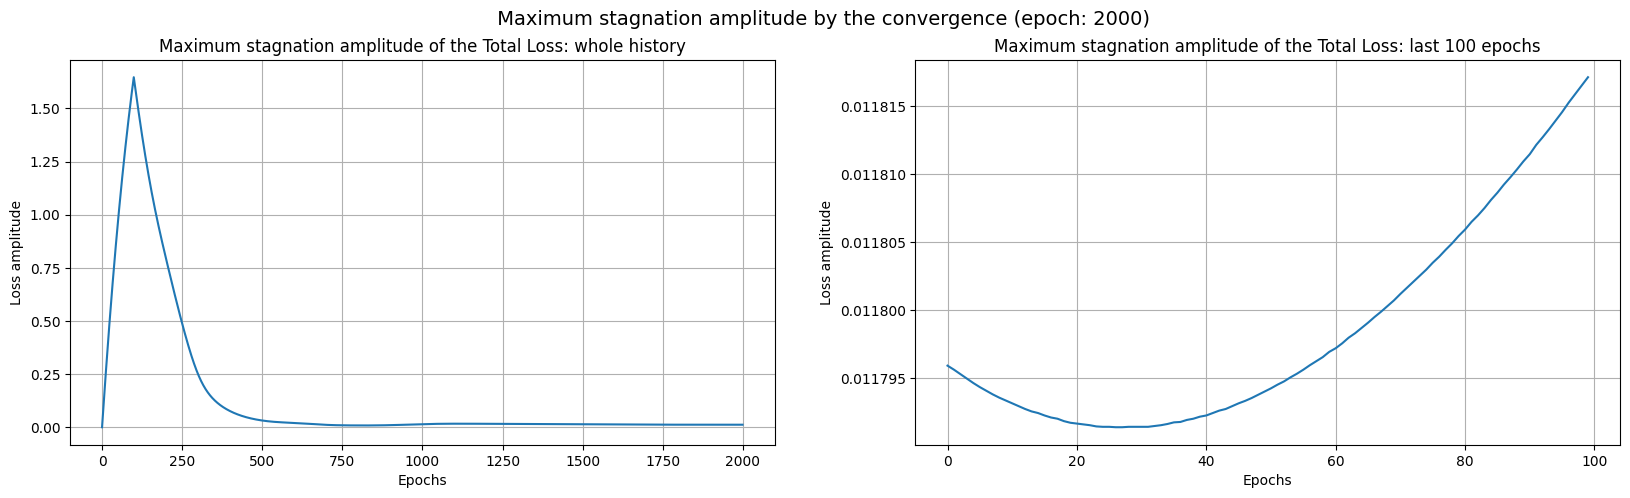

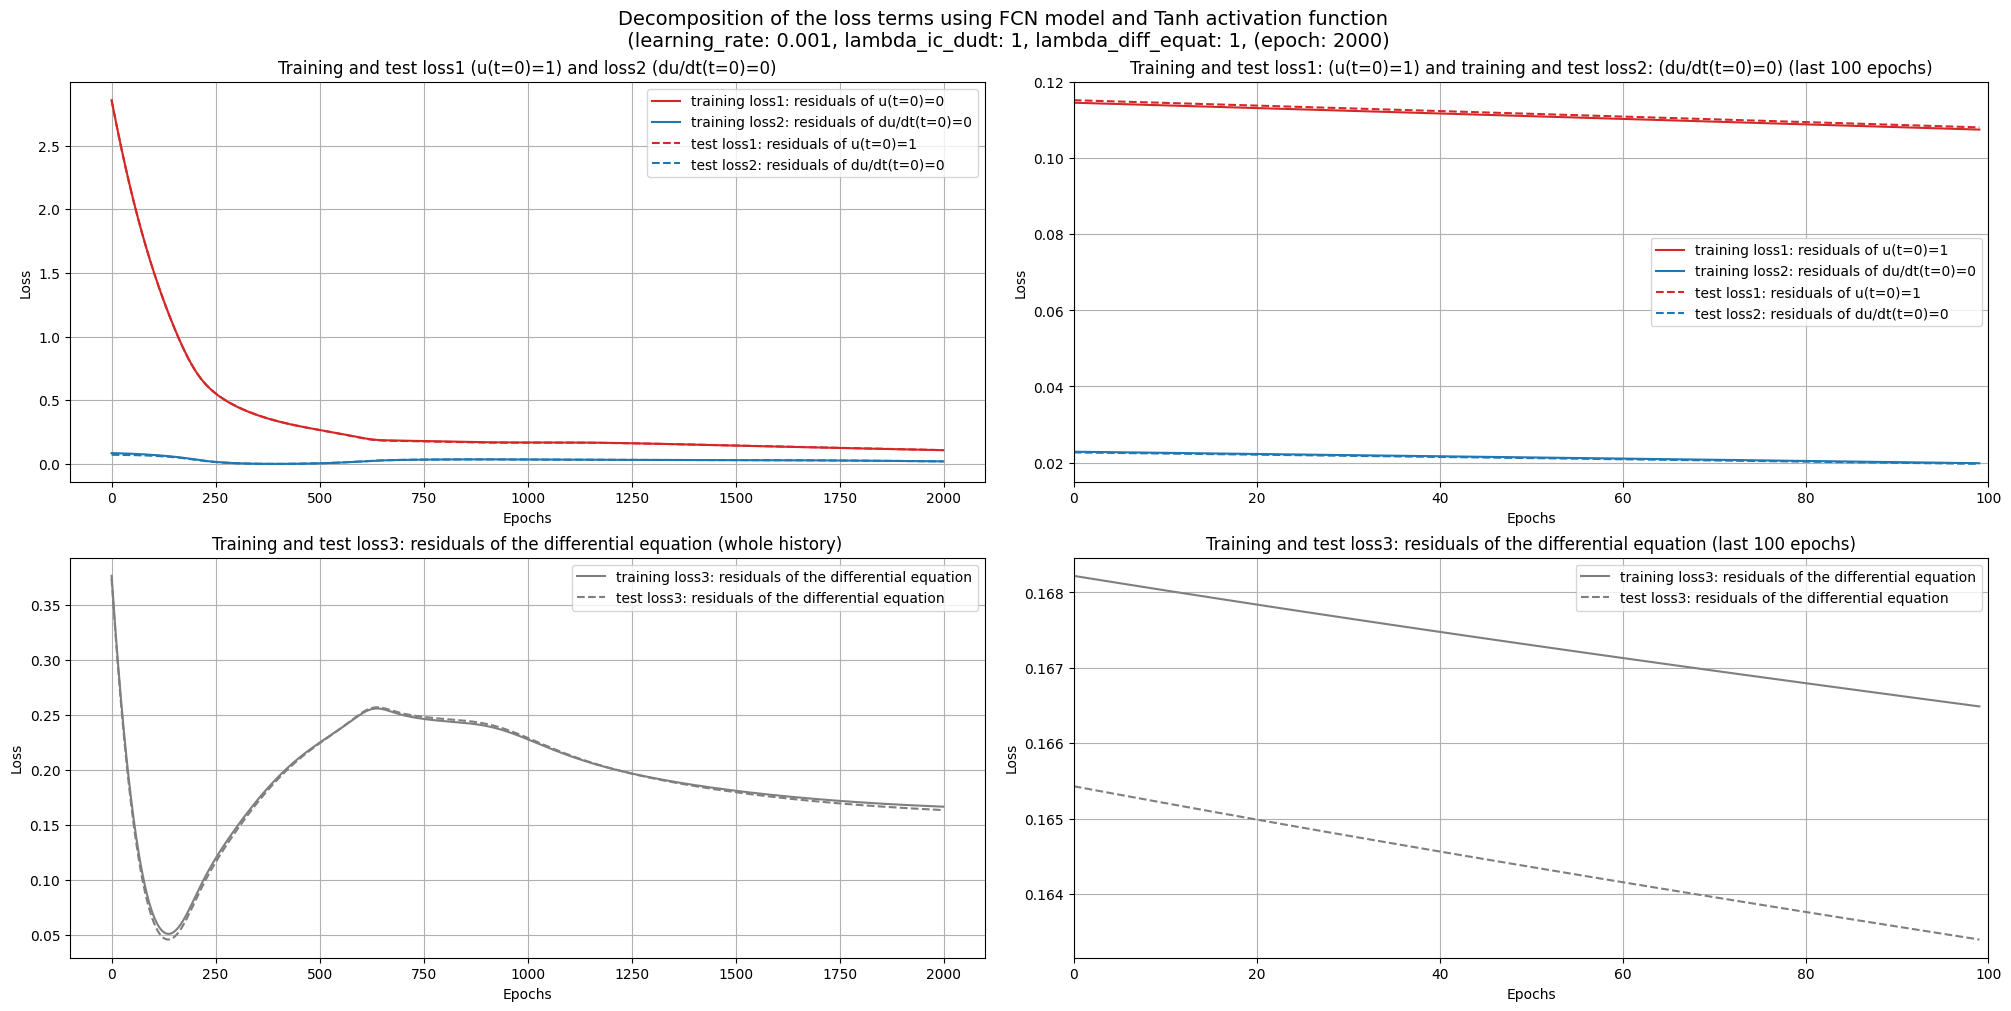

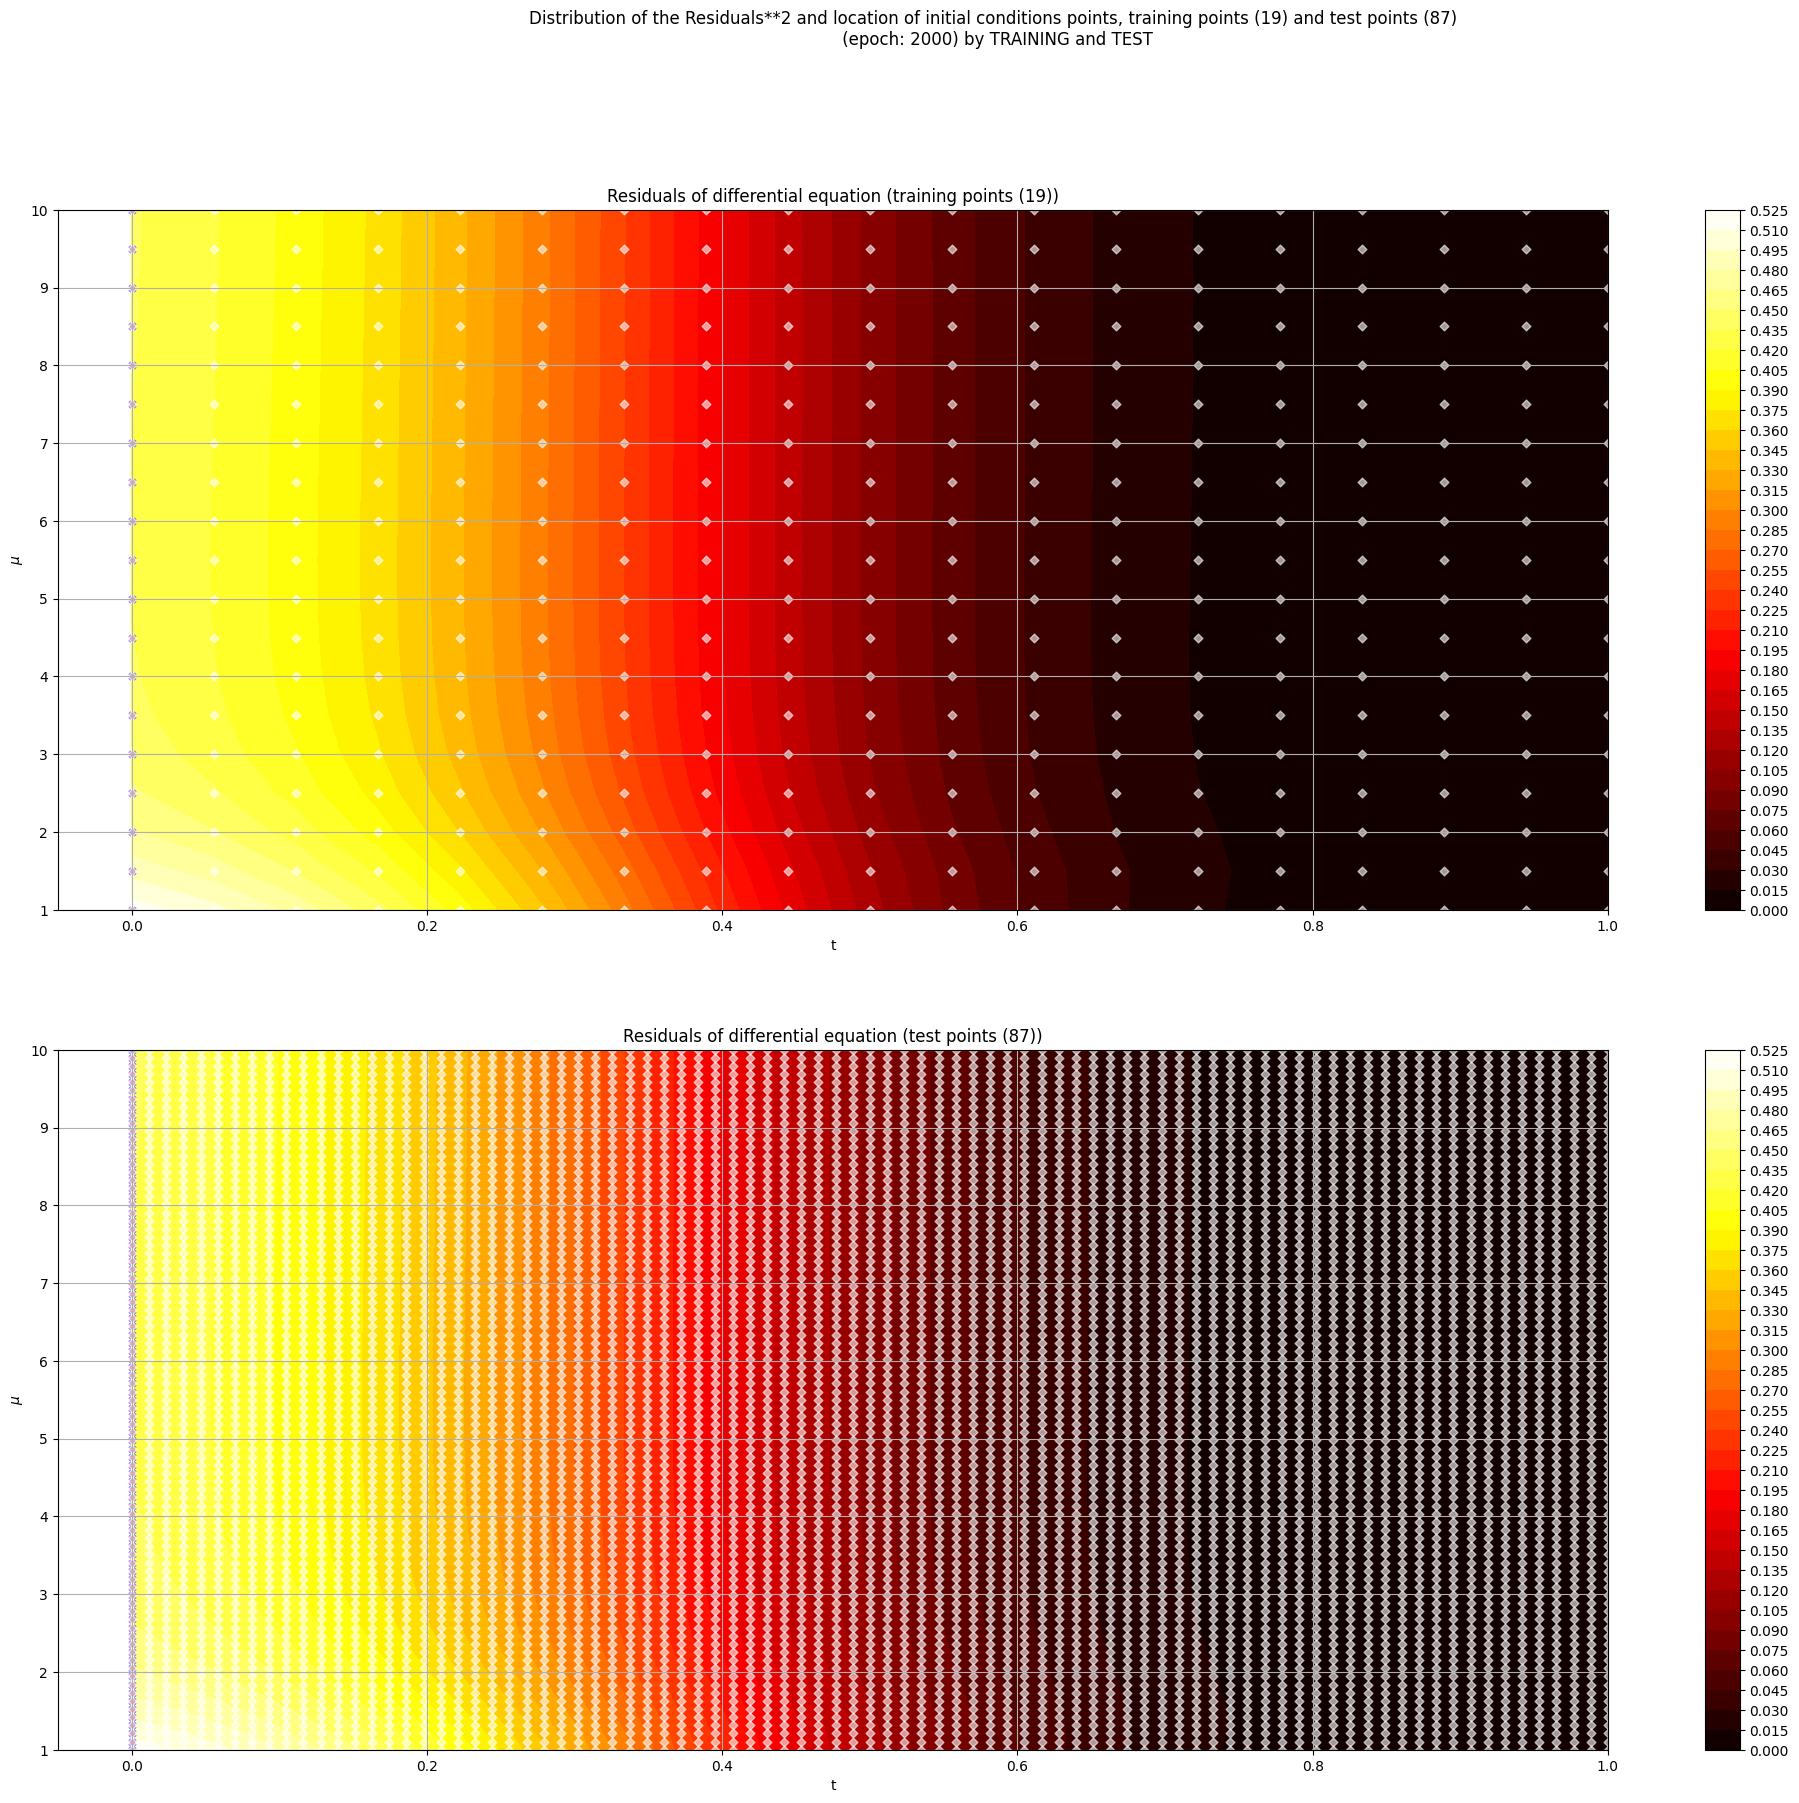

Saved the checkpoint corresponding to epoch: 2000
RESULTS PLOTTED FOR EPOCH: 2000
########################################################################################################################################################################################################
Training elapsed time (s): 14.23691987991333
Saved the checkpoint corresponding to last epoch: 2000


In [29]:
# Train original model
#train_model = TrainModel(original_model, num_epochs=1000, checkpoint_interval=100, loss_threshold=0.01)
#train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_domain_t_mu, k, learning_rate = 0.0001, num_epochs= 20000, lambda_ic_dudt= 1e-1, lambda_diff_equat = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200)
#train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_physic_in_t_mu, u_exact, test_mu = 5, learning_rate = 1e-2, num_epochs= 50000, lambda_ic_dudt= 1, lambda_diff_equat = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.00001, stagnation_range = 100)
train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu, u_exact= exact_solution, test_mu = 5, mass = 1, w0 = 20, learning_rate = 1e-3, num_epochs= 2000, lambda_ic_dudt= 1, lambda_diff_equat = 1, checkpoint_interval = 1000, stagnation_amplitude= 1e-4, stagnation_range = 100)

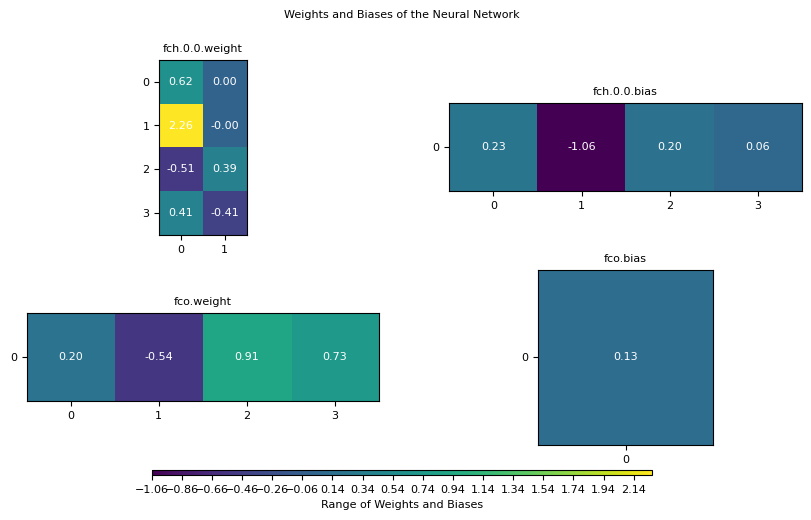

In [30]:
original_model.plot_weights(fig_size = (10,5), font_size = 8)

In [31]:
k

400

## STEP 6: Inference/Prediction with a constant mu

In [32]:
test_mu = 1
test_in_t_constant_mu = torch.stack([torch.linspace(0,1, test_point_resolution), test_mu*torch.ones(test_point_resolution)], -1).view(-1,2)
test_in_t_constant_mu.size

<function Tensor.size>

In [33]:
test_predicted = original_model(test_in_t_constant_mu)

In [34]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])

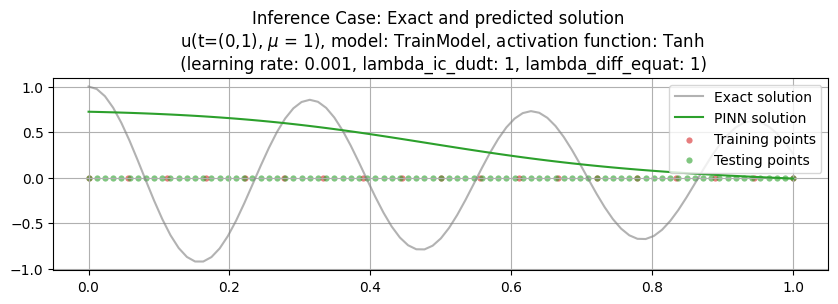

In [35]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_physic_in_t_mu[0].detach().numpy(), 
                 u_exact.detach().numpy(), 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_physic_in_t_mu[0].detach().numpy(), 
                 test_predicted[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(test_physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Testing points")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda_ic_dudt: {train_model.lambda_ic_dudt}, lambda_diff_equat: {train_model.lambda_diff_equat})")
#plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda_ic_dudt: {train_model.lambda_ic_dudt}, lambda_diff_equat: {train_model.lambda_diff_equat})")

plt.grid()
plt.legend()
plt.show()

test_mu = 10

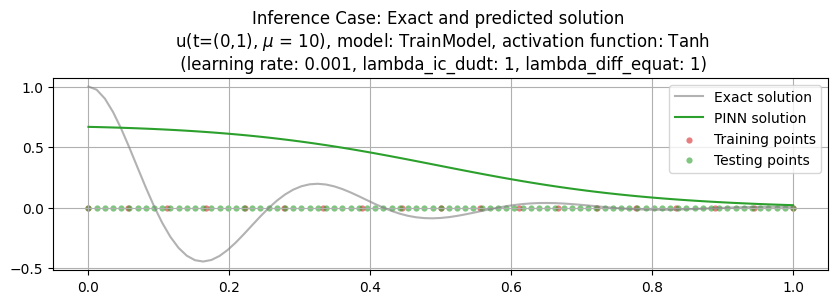

In [36]:
test_mu = 10
test_in_t_constant_mu = torch.stack([torch.linspace(0,1, test_point_resolution), test_mu*torch.ones(test_point_resolution)], -1).view(-1,2)
test_in_t_constant_mu.size
test_predicted = original_model(test_in_t_constant_mu)
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_physic_in_t_mu[0].detach().numpy(), 
                 u_exact.detach().numpy(), 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_physic_in_t_mu[0].detach().numpy(), 
                 test_predicted[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_physic_in_t_mu[0].detach().numpy(), 
            torch.zeros_like(test_physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Testing points")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda_ic_dudt: {train_model.lambda_ic_dudt}, lambda_diff_equat: {train_model.lambda_diff_equat})")
#plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda_ic_dudt: {train_model.lambda_ic_dudt}, lambda_diff_equat: {train_model.lambda_diff_equat})")

plt.grid()
plt.legend()
plt.show()